In [160]:
from dotenv import load_dotenv

load_dotenv()

True

In [161]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [162]:
# Reload the module to pick up the latest changes
import importlib
import document_processing
import database.setup_db
importlib.reload(document_processing)
importlib.reload(database.setup_db)
from document_processing import RAGStore


In [163]:
# Ensure the database table exists with correct schema
from database.setup_db import DBManager
import os
import sqlite3

db_path = "database/database.db"
# Create database directory if it doesn't exist
os.makedirs("database", exist_ok=True)

# Drop and recreate the table to ensure correct schema
db_manager = DBManager(db_path)
db_manager.drop_doc_table()  # Drop existing table if it has wrong schema
db_manager.create_doc_table()  # Create with correct schema
db_manager.conn.commit()
print("Database table created successfully")


Table 'docs' dropped successfully
Database table created successfully


In [164]:
from langgraph.graph import MessagesState
# RAGStore is already imported in Cell 2 after reload
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str, vector_db_path: str, relational_db_path: str) -> tuple[str, list]:
    """Retrieve relevant context from the vector store based on a query.
    
    Args:
        query: The search query to find relevant documents.
        
    Returns:
        A tuple containing (serialized_string, retrieved_documents).
    """
    doc_processor = RAGStore(vector_db_path, embeddings, relational_db_path)
    retrieved_docs = doc_processor.vector_store.similarity_search(query, k=2)
    print(retrieved_docs)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

TOOLS = [retrieve_context]
TOOLS_BY_NAME = {tool.name : tool for tool in TOOLS}

model_with_tools = gemini.bind_tools(TOOLS)

In [165]:
from langchain.messages import SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END

class LocalRagState(MessagesState):
    summary: str
    llm_calls: int
    vector_db_path: str
    relational_db_path: str

SYSTEM_PROMPT = (
    "You have access to a tool that retrieves context from a codebase. "
    "Use the tool to help answer user queries."
)


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content=SYSTEM_PROMPT
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

def tool_node(state: LocalRagState):
    """Performs the tool call"""
    result = []
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_call["args"]["vector_db_path"] = state["vector_db_path"]
        tool_call["args"]["relational_db_path"] = state["relational_db_path"]
        tool = TOOLS_BY_NAME[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        
        if isinstance(observation, tuple):
            content = observation[0]
        else:
            content = observation
        result.append(ToolMessage(content=content, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: LocalRagState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tool_node"

    return END

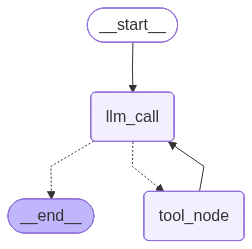

In [166]:
from IPython.display import Image, display

app = StateGraph(LocalRagState)


app.add_node("llm_call", llm_call)
app.add_node("tool_node", tool_node)

app.add_edge(START, "llm_call")
app.add_conditional_edges("llm_call", 
    should_continue,
    ["tool_node", END]
)

app.add_edge("tool_node", "llm_call")

agent = app.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [167]:
rag = RAGStore("milvus/milvus_rag.db", embeddings, "database/database.db")
rag.add_documents("../app.py")

messages = [HumanMessage(content="How is the app.py file structured?")]
messages = agent.invoke({"messages": messages, "vector_db_path":"milvus/mivlus_rag.db", "relational_db_path":"database/database.db", "embeddings": embeddings})

Split ../app.py into 7 sub_documents
[Document(metadata={'hash': 'd3ba5cd09bc46a2dbee11d4a0c4add68', 'id': '46a68a1e-6f23-4f0d-a1a0-68fa4c22151a', 'indexed_at': '2025-11-24T12:22:20.197838', 'source': '../design.md', 'start_index': 2473, 'uuid': '46a68a1e-6f23-4f0d-a1a0-68fa4c22151a'}, page_content='## App\n\nWe will use typer with rich print to design the CLI functionality.\n\n\n## Questions: \n\n1 - How to make sure that the agent connects to one vector store?'), Document(metadata={'hash': 'd3ba5cd09bc46a2dbee11d4a0c4add68', 'id': '8f0435b9-b3a9-4e68-9c40-bcd09640047d', 'indexed_at': '2025-11-24T12:27:29.896151', 'source': '../design.md', 'start_index': 2473, 'uuid': '8f0435b9-b3a9-4e68-9c40-bcd09640047d'}, page_content='## App\n\nWe will use typer with rich print to design the CLI functionality.\n\n\n## Questions: \n\n1 - How to make sure that the agent connects to one vector store?')]


In [169]:
for m in messages['messages']:
    print(m)

content='How is the app.py file structured?' additional_kwargs={} response_metadata={} id='bb4788f5-f311-456c-b9ea-8f12f6d82a0a'
content='' additional_kwargs={'function_call': {'name': 'retrieve_context', 'arguments': '{"vector_db_path": "vector_db", "relational_db_path": "relational_db", "query": "structure of app.py"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--68f494eb-5c6f-4543-930c-2d7143bcc2b5-0' tool_calls=[{'name': 'retrieve_context', 'args': {'vector_db_path': 'milvus/mivlus_rag.db', 'relational_db_path': 'database/database.db', 'query': 'structure of app.py'}, 'id': '34f122be-d58b-4557-9798-06d87f0a7b86', 'type': 'tool_call'}] usage_metadata={'input_tokens': 150, 'output_tokens': 193, 'total_tokens': 343, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 15